#### Import Libraries & Load Data

In [3]:
#import libraries
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
import numpy as np

In [1]:
%matplotlib inline

In [42]:
#Load Dataset
Vedanta_data= pd.read_csv('../data/vedanta.csv')

In [43]:
Vedanta_data= Vedanta_data[2:]

In [44]:
# Data Cleaning
Vedanta_data = Vedanta_data.rename(columns={'Price':'Date'})
Vedanta_data['Date'] = pd.to_datetime(Vedanta_data['Date'])         # ensure datetime type
Vedanta_data.set_index('Date', inplace=True)              # make it the index
Vedanta_data.sort_index(inplace=True) 
# Convert OHLCV columns to numeric
cols = ['Open', 'High', 'Low', 'Close', 'Volume']
Vedanta_data[cols] = Vedanta_data[cols].apply(pd.to_numeric, errors='coerce')

In [46]:
print(Vedanta_data)
print(Vedanta_data.info())

                 Close        High         Low        Open    Volume
Date                                                                
2024-04-01  261.427612  262.109597  248.560833  248.697224  17331916
2024-04-02  273.976135  274.567211  259.927259  260.927509  27928247
2024-04-03  271.702850  280.068545  270.793537  273.885225  19966252
2024-04-04  281.841705  284.160443  274.339870  278.295361  24723528
2024-04-05  290.025513  293.162627  278.204439  282.841915  22256365
...                ...         ...         ...         ...       ...
2025-04-23  418.200012  419.700012  410.600006  416.000000   8692823
2025-04-24  420.250000  431.000000  416.500000  418.200012  13580010
2025-04-25  413.299988  425.799988  409.500000  422.850006  11205671
2025-04-28  416.100006  417.649994  408.950012  414.000000   6864935
2025-04-29  416.299988  421.399994  414.399994  418.000000   7054453

[266 rows x 5 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 266 entries, 2024-04-01 to

## Moving Average Crossover Strategy

In [50]:
'''
Moving Average Crossover Strategy : 
    - We use 2 Simple Moving Average : Most popular SMA 50 & SMA 100
    - CrossOver - Buy Signal - Shorter Moving Avg. is grater than the Longer Moving Avg.
    - CrossUnder - Sell Signal - Shorter Moving Avg. is Less than the Longer Moving Avg.
'''
# Add SMAs

Vedanta_data['SMA_50'] = Vedanta_data['Close'].rolling(window=50).mean()
Vedanta_data['SMA_100'] = Vedanta_data['Close'].rolling(window=100).mean()

# Initialize signal column
Vedanta_data['Signal'] = 0

# Set signals based on SMA crossover
Vedanta_data.loc[Vedanta_data['SMA_50'] < Vedanta_data['SMA_100'], 'Signal'] = -1  # SELL zone
Vedanta_data.loc[Vedanta_data['SMA_50'] > Vedanta_data['SMA_100'], 'Signal'] = 1   # BUY zone

# Detect position changes (crossovers)
Vedanta_data['Position'] = Vedanta_data['Signal'].diff()

# Explanation:
#  2 → from -1 to 1 → BUY signal
# -2 → from  1 to -1 → SELL signal

# Generate markers for mplfinance (NaN everywhere else)
Vedanta_data['Buy_Marker'] = np.where(Vedanta_data['Position'] == 2, Vedanta_data['Low'] * 0.98, np.nan)
Vedanta_data['Sell_Marker'] = np.where(Vedanta_data['Position'] == -2, Vedanta_data['High'] * 1.02, np.nan)

In [51]:
print("SMA_50 non-NaN:", Vedanta_data['SMA_50'].notna().sum())
print("SMA_100 non-NaN:", Vedanta_data['SMA_100'].notna().sum())
print("Buy Marker non-NaN:", Vedanta_data['Buy_Marker'].notna().sum())
print("Sell Marker non-NaN:", Vedanta_data['Sell_Marker'].notna().sum())

SMA_50 non-NaN: 217
SMA_100 non-NaN: 167
Buy Marker non-NaN: 0
Sell Marker non-NaN: 1


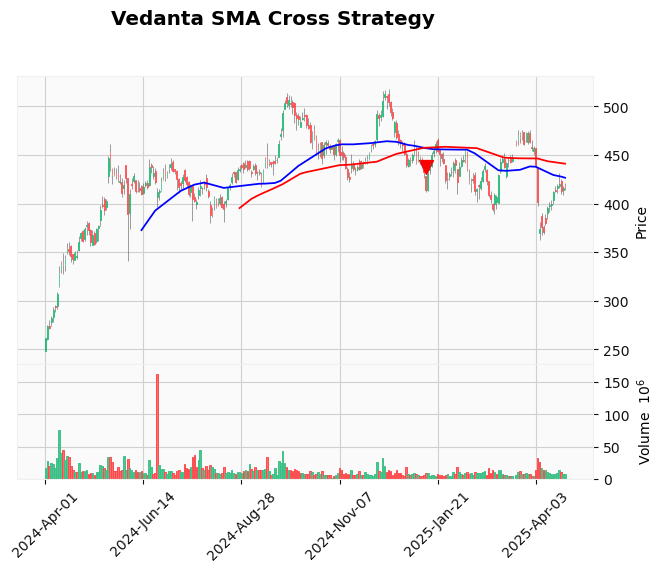

In [53]:
import mplfinance as mpf

apds = []

# Optional: Only include if they have real values
if Vedanta_data['SMA_50'].notna().any():
    apds.append(mpf.make_addplot(Vedanta_data['SMA_50'], color='blue'))

if Vedanta_data['SMA_100'].notna().any():
    apds.append(mpf.make_addplot(Vedanta_data['SMA_100'], color='red'))

if Vedanta_data['Buy_Marker'].notna().any():
    apds.append(mpf.make_addplot(Vedanta_data['Buy_Marker'], type='scatter', marker='^', color='green', markersize=100))

if Vedanta_data['Sell_Marker'].notna().any():
    apds.append(mpf.make_addplot(Vedanta_data['Sell_Marker'], type='scatter', marker='v', color='red', markersize=100))

# Plot
mpf.plot(Vedanta_data, type='candle', style='yahoo', volume=True, title='Vedanta SMA Cross Strategy', addplot=apds)

# RSI + SMA Strategy with Chart

### Step -1 Load Data & Clean it

In [148]:
'''
DataLoder:
    Input: path of csv, where the data is stored(Extracted from Yfinance)
    Returns: Pandas DataFrame Object
    Task Performed:
        - Load CSV
        - rename 'Price' to 'Date'
        - Row 0 and 1 Other data then stock - So remove it.
        - Date is not in Date formate. so convert it into Date
        - All other to float
'''
def DataLoder(path):
    import pandas as pd
    import numpy as np
    import os
    try:
        isExist = os.path.exists(path)
        if isExist == False:
            return 0
        stock_data = pd.read_csv(path)
        if stock_data['Price'][0]== 'Ticker':
            stock_data=stock_data[1:]
        if stock_data['Price'][1]=='Date':
            stock_data=stock_data[1:]
        stock_data=stock_data.rename(columns={'Price':'Date'})
        stock_data['Date']=pd.to_datetime(stock_data['Date'])
        ignore = ['Date']
        stock_data = (stock_data.set_index(ignore, append=True)
                        .astype(float)
                        .reset_index(ignore)
                        )
        stock_data.set_index('Date', inplace=True)              # make it the index
        return stock_data
    
    except:
        print("Error Occoured...")
        return 0



In [149]:
# Load Reliance Data

Reliance_data = DataLoder('../data/RELIANCE.BO_2023-04-01_to_2025-05-06.csv')

if isinstance(Reliance_data, pd.DataFrame): 
    print(Reliance_data.info())
else:
    print("Something went Wrong...")


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 510 entries, 2023-04-03 to 2025-05-05
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   510 non-null    float64
 1   High    510 non-null    float64
 2   Low     510 non-null    float64
 3   Open    510 non-null    float64
 4   Volume  510 non-null    float64
dtypes: float64(5)
memory usage: 23.9 KB
None


### Step 2: Calculate RSI & SMA

In [150]:
'''
RSI_Calculator:
    Input: Pandas Dataframe Object containing Stock Data
    Output: Pandas Dataframe Object containing RSI column
    Relative Strength Index (RSI) is a momentum indicator that measures the speed and magnitude of recent price changes. It ranges from 0 to 100.
    Mathematical Formula for RSI:
        - 𝑅𝑆𝐼 = 100 −(100 /1+𝑅𝑆) where 𝑅𝑆= Average Gain/Average Loss
        - RSI is typically calculated over 14 periods (14 days if using daily data).
        
'''
def RSI_Calculator(stock_data):
    delta = stock_data['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    stock_data['RSI'] = 100 - (100 / (1 + rs))
    return stock_data


In [151]:
'''
SMA_Calculator:
    Input: Pandas Dataframe Object containing Stock Data , SMA Day in numbers
    Output: Pandas Dataframe Object containing SMA column
'''
def SMA_Calculator(stock_data ,days):
    stock_data[f'SMA_{days}'] = stock_data['Close'].rolling(days).mean()
    return stock_data

In [152]:
#Calculate RSI of Reliance Data
Reliance_data = RSI_Calculator(Reliance_data)
Reliance_data

,Close,High,Low,Open,Volume,RSI
Date,,,,,,
2023-04-03,1149.834595,1158.414850,1141.574820,1156.417807,428430.0,NaN
2023-04-05,1146.752686,1157.157585,1138.369630,1154.765900,516000.0,NaN
2023-04-06,1154.395996,1161.053128,1143.078896,1144.040457,289284.0,NaN
2023-04-10,1146.308838,1159.031260,1144.977315,1156.861576,187190.0,NaN
2023-04-11,1152.078369,1154.396013,1146.012958,1148.971683,210020.0,NaN
...,...,...,...,...,...,...
2025-04-28,1368.500000,1374.900024,1320.150024,1332.349976,1269304.0,69.970019
2025-04-29,1400.300049,1410.900024,1370.199951,1370.349976,6415191.0,83.946552
2025-04-30,1408.349976,1411.849976,1373.500000,1404.900024,3375628.0,96.992044


In [153]:
# Calculate SMA_20 &SMA_50
Reliance_data = SMA_Calculator(Reliance_data,20)
Reliance_data = SMA_Calculator(Reliance_data,50)
Reliance_data

,Close,High,Low,Open,Volume,RSI,SMA_20,SMA_50
Date,,,,,,,,
2023-04-03,1149.834595,1158.414850,1141.574820,1156.417807,428430.0,NaN,NaN,NaN
2023-04-05,1146.752686,1157.157585,1138.369630,1154.765900,516000.0,NaN,NaN,NaN
2023-04-06,1154.395996,1161.053128,1143.078896,1144.040457,289284.0,NaN,NaN,NaN
2023-04-10,1146.308838,1159.031260,1144.977315,1156.861576,187190.0,NaN,NaN,NaN
2023-04-11,1152.078369,1154.396013,1146.012958,1148.971683,210020.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2025-04-28,1368.500000,1374.900024,1320.150024,1332.349976,1269304.0,69.970019,1257.315002,1241.245996
2025-04-29,1400.300049,1410.900024,1370.199951,1370.349976,6415191.0,83.946552,1263.702502,1244.183997
2025-04-30,1408.349976,1411.849976,1373.500000,1404.900024,3375628.0,96.992044,1270.200000,1247.658997


In [154]:
Reliance_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 510 entries, 2023-04-03 to 2025-05-05
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   510 non-null    float64
 1   High    510 non-null    float64
 2   Low     510 non-null    float64
 3   Open    510 non-null    float64
 4   Volume  510 non-null    float64
 5   RSI     496 non-null    float64
 6   SMA_20  491 non-null    float64
 7   SMA_50  461 non-null    float64
dtypes: float64(8)
memory usage: 35.9 KB


In [155]:
Reliance_data['Signal'] = 0
Reliance_data.loc[(Reliance_data['RSI']<30)&(Reliance_data['SMA_20']>Reliance_data['SMA_50']),'Signal']=1
Reliance_data.loc[(Reliance_data['RSI']>70)&(Reliance_data['SMA_20']<Reliance_data['SMA_50']),'Signal']= -1
Reliance_data['Position'] = Reliance_data['Signal'].diff()

In [156]:
Reliance_data.loc[Reliance_data['Position']==1]

,Close,High,Low,Open,Volume,RSI,SMA_20,SMA_50,Signal,Position
Date,,,,,,,,,,
2023-08-01,1239.040161,1261.896363,1235.711595,1256.398113,340426.0,29.580450,1302.170758,1264.225344,1,1.0
2023-11-17,1169.955688,1178.472625,1168.540281,1170.700614,1146200.0,69.325817,1146.377551,1165.873003,0,1.0
2023-11-28,1189.174805,1191.285428,1179.465914,1188.405024,706244.0,66.626706,1163.330829,1162.442373,0,1.0
2024-06-04,1387.349976,1493.799809,1350.376725,1493.799809,2070856.0,46.566604,1425.655200,1441.908743,0,1.0
2024-07-26,1498.716309,1502.738835,1480.862823,1489.230871,1542328.0,29.975268,1546.384113,1487.109363,1,1.0
2024-08-02,1489.081909,1498.964665,1482.799750,1490.050289,1224924.0,26.923086,1534.192157,1494.683774,1,1.0
2024-08-27,1500.224976,1512.550049,1499.000000,1511.500000,145120.0,68.858266,1477.494696,1503.619443,0,1.0
2024-08-30,1509.875000,1541.974976,1503.474976,1541.974976,1391808.0,67.922523,1478.749609,1506.449055,0,1.0
2024-09-05,1493.574951,1526.025024,1487.500000,1519.724976,624506.0,59.637185,1489.114313,1511.483384,0,1.0


In [171]:
# Step 5: Identify buy/sell points
buy_signals = Reliance_data[Reliance_data['Signal'] == 1].reindex(Reliance_data.index)
sell_signals = Reliance_data[Reliance_data['Signal'] == -1].reindex(Reliance_data.index)

In [172]:
buy_signals

,Close,High,Low,Open,Volume,RSI,SMA_20,SMA_50,Signal,Position
Date,,,,,,,,,,
2023-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2025-04-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-04-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [173]:
sell_signals

,Close,High,Low,Open,Volume,RSI,SMA_20,SMA_50,Signal,Position
Date,,,,,,,,,,
2023-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2025-04-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-04-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


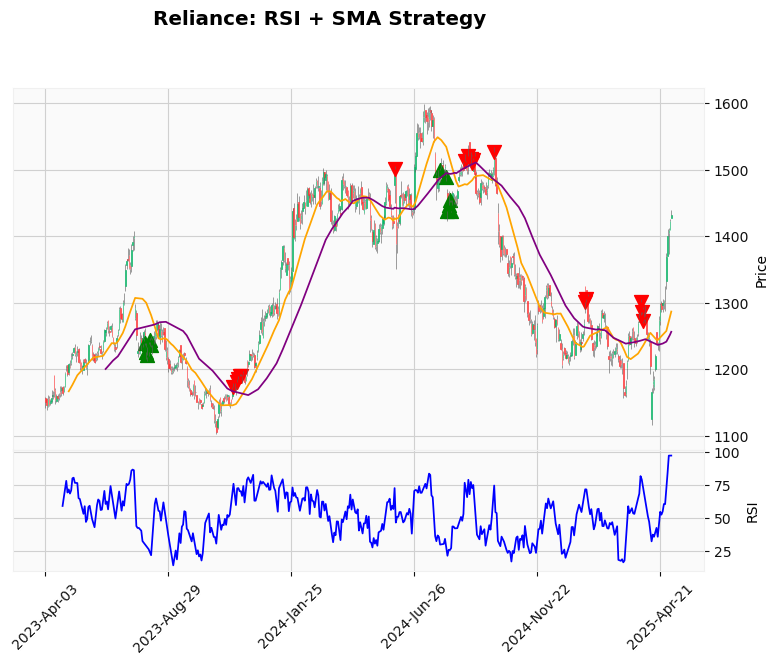

In [175]:
# Step 6: Plot with mplfinance
apds = [
    mpf.make_addplot(Reliance_data['SMA_20'], color='orange'),
    mpf.make_addplot(Reliance_data['SMA_50'], color='purple'),
    mpf.make_addplot(Reliance_data['RSI'], panel=1, color='blue', ylabel='RSI'),
]

# Add only if signals exist
if not buy_signals.empty:
    apds.append(mpf.make_addplot(buy_signals['Close'], type='scatter', color='green', marker='^', markersize=100))

if not sell_signals.empty:
    apds.append(mpf.make_addplot(sell_signals['Close'], type='scatter', color='red', marker='v', markersize=100))


mpf.plot(Reliance_data[['Open', 'High', 'Low', 'Close', 'Volume']],
         type='candle',
         style='yahoo',
         addplot=apds,
         title='Reliance: RSI + SMA Strategy',
         panel_ratios=(3, 1),
         volume=False,
         figscale=1.2)


In [176]:
print("RSI < 30:", (Reliance_data['RSI'] < 30).sum())
print("RSI > 70:", (Reliance_data['RSI'] > 70).sum())
print("SMA_20 > SMA_50:", (Reliance_data['SMA_20'] > Reliance_data['SMA_50']).sum())
print("SMA_20 < SMA_50:", (Reliance_data['SMA_20'] < Reliance_data['SMA_50']).sum())

RSI < 30: 58
RSI > 70: 82
SMA_20 > SMA_50: 207
SMA_20 < SMA_50: 254


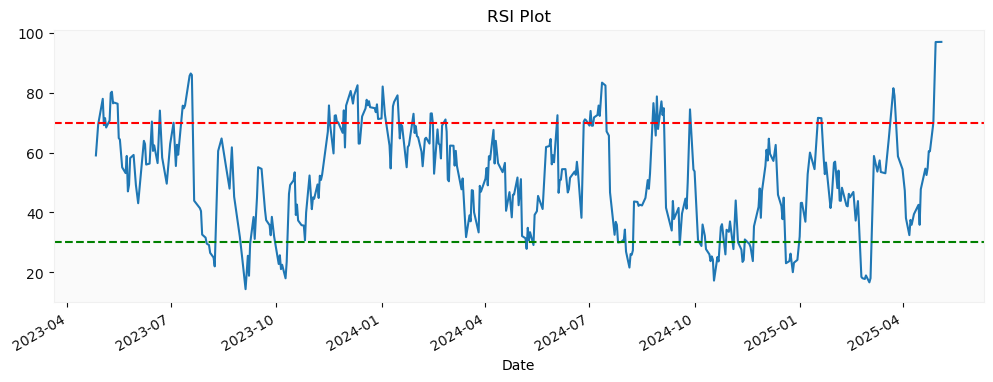

In [177]:
import matplotlib.pyplot as plt

Reliance_data['RSI'].plot(figsize=(12, 4), title='RSI Plot')
plt.axhline(30, color='green', linestyle='--')
plt.axhline(70, color='red', linestyle='--')
plt.grid()
plt.show()

In [166]:
print("Buy Conditions Met:", ((Reliance_data['RSI'] < 30) & (Reliance_data['SMA_20'] > Reliance_data['SMA_50'])).sum())
print("Sell Conditions Met:", ((Reliance_data['RSI'] > 70) & (Reliance_data['SMA_20'] < Reliance_data['SMA_50'])).sum())

Buy Conditions Met: 12
Sell Conditions Met: 17


In [182]:
Reliance_data['Buy_Cond'] = ((Reliance_data['RSI'] < 30) & (Reliance_data['SMA_20'] > Reliance_data['SMA_50']))
Reliance_data['Sell_Cond'] = ((Reliance_data['RSI'] > 70) & (Reliance_data['SMA_20'] < Reliance_data['SMA_50']))

# Mark only the first day the condition is True (previous day False or NaN)
Reliance_data['Buy_Signal'] = (Reliance_data['Buy_Cond']) & (~Reliance_data['Buy_Cond'].shift(1, fill_value=False))
Reliance_data['Sell_Signal'] = (Reliance_data['Sell_Cond']) & (~Reliance_data['Sell_Cond'].shift(1, fill_value=False))

buy_signals = Reliance_data[Reliance_data['Buy_Signal']].reindex(Reliance_data.index)
sell_signals = Reliance_data[Reliance_data['Sell_Signal']].reindex(Reliance_data.index)

In [183]:
buy_signals

,Close,High,Low,Open,Volume,RSI,SMA_20,SMA_50,Signal,Position,Buy_Cond,Sell_Cond,Buy_Signal,Sell_Signal
Date,,,,,,,,,,,,,,
2023-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-04-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-04-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


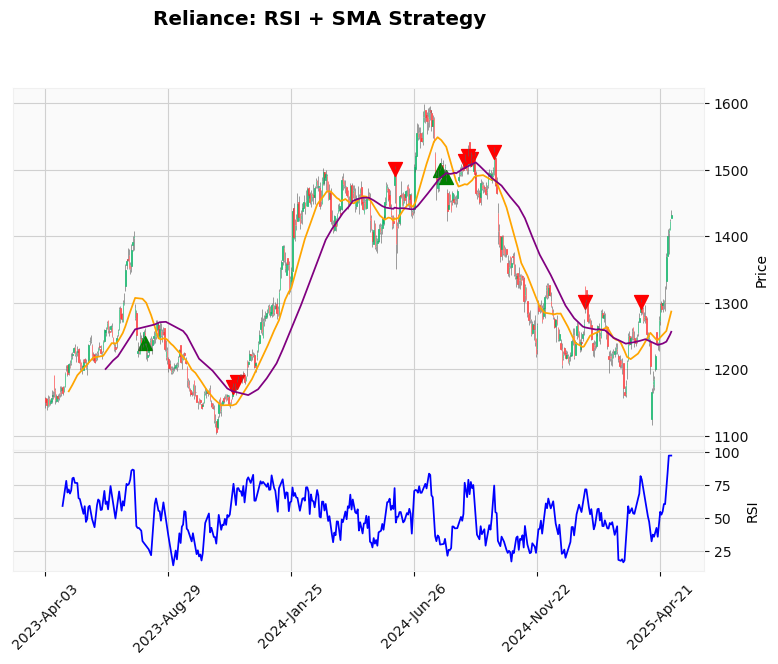

In [184]:
# Step 6: Plot with mplfinance
apds = [
    mpf.make_addplot(Reliance_data['SMA_20'], color='orange'),
    mpf.make_addplot(Reliance_data['SMA_50'], color='purple'),
    mpf.make_addplot(Reliance_data['RSI'], panel=1, color='blue', ylabel='RSI'),
]

# Add only if signals exist
if not buy_signals.empty:
    apds.append(mpf.make_addplot(buy_signals['Close'], type='scatter', color='green', marker='^', markersize=100))

if not sell_signals.empty:
    apds.append(mpf.make_addplot(sell_signals['Close'], type='scatter', color='red', marker='v', markersize=100))


mpf.plot(Reliance_data[['Open', 'High', 'Low', 'Close', 'Volume']],
         type='candle',
         style='yahoo',
         addplot=apds,
         title='Reliance: RSI + SMA Strategy',
         panel_ratios=(3, 1),
         volume=False,
         figscale=1.2)
